# Cuaderno 2: calibración de IPP

En este cuaderno vamos a preparar los datos para IPP, y a correr el algoritmo de calibración. Al final obtendremos una tabla con los parámetros de cada indicador así como las métricas de bondad de ajuste correspondientes. Después, verificaremos que los parámetros obtenidos son consistentes con los que fueron calculados para el reporte (para los cuales se empleó un criterio de precisión más exigente que el de este cuaderno).

## Importamos librerías de Python

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed # esta librería nos ayuda a correr múltiples simulaciones en paralelo

## Importamos el calibrador de IPP

Si IPP está instalado en la PC y los archivos `ppi.py` y `calibrator.py` están enla misma carpeta que tu archivo de trabajo (o que este cuaderno), entonces la importación es más fácil. Como aquí vamos a usar los archivos guardados en el repositorio, la inportación requiere algunos pasos intermedios como descargar los archivos.

In [2]:
import requests
url = 'https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/code/calibrator.py'
r = requests.get(url)
with open('calibrator.py', 'w') as f:
    f.write(r.text)
import calibrator

## Hiperparámetros de la calibración

In [3]:
max_steps = 54 # máximo número de pasos en cada simulación
scalar = 100 # escalar de los indicadores (porcentaje)
min_value = 1e-2 # valor que se le asigna a las brechas que no son positivas

## Cargamos datos de los indicadores

In [4]:
# cargamos base de datos
datos = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/base_final.csv')

# obtenemos columnas con los años
anios_c = np.array([c for c in datos.columns if c.isnumeric()])

# guardamos el número de años
num_years = len(anios_c)

# extraemos las series de tiempo como una matriz (renglón=indicador; columna=tiempo)
series = datos[anios_c].values

# obetnemos vector indicando qué indicadores son instrumentales
R = datos.Instrumental.values

# obetenemos los parámetros de gobernanza
cc = datos['control_corrupcion'].values[0]
rl = datos['estado_de_derecho'].values[0]

## Cargamos la red de interdependencias

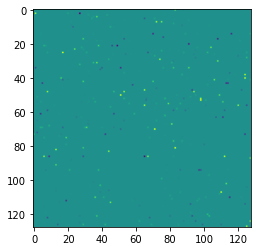

In [5]:
A = np.loadtxt('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/red/A.csv', dtype=float, delimiter=',')

# hacemos un plot de la matriz de adyacencia
plt.imshow(A)
plt.show()

## Construimos vectores con condiciones iniciales y finales para calibrar parámetros $\alpha$

In [6]:
I0 = series[:,0]*scalar # valores iniciales reescalados
IF = series[:,-1]*scalar # valores finales reescalados
G = IF - I0 # brechas cerradas durante periodo histórico
G[G<min_value] = min_value # corregimos brechas que estén por debajo del valor mínimo
IF = G + I0 # ajustamos valores finales para reflejar brechas corregidas

condiciones violadas: 0


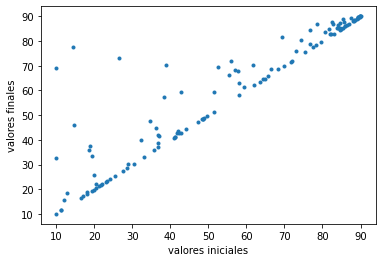

In [7]:
# revisamos que todos los valores iniciales estén por debajo de los finales
print('condiciones violadas:', sum(I0>=IF) )
plt.plot(I0, IF, '.')
plt.xlabel('valores iniciales')
plt.ylabel('valores finales')
plt.show()

## Calculamos tasas de crecimiento exitoso para calibrar parámetros $\beta$

In [8]:
sc = series[:, 1::]-series[:, 0:-1] # primeras diferencias en las series de tiempo
success_emp = np.sum(sc>0, axis=1)/sc.shape[1] # tasas de crecimiento
maxg = .95 # tasa mínima
ming = .05 # tasa máxima
# renormalizamos tasas de crecimiento exitoso
success_emp = (maxg - ming)*(success_emp - success_emp.min())/(success_emp.max() - success_emp.min()) + ming

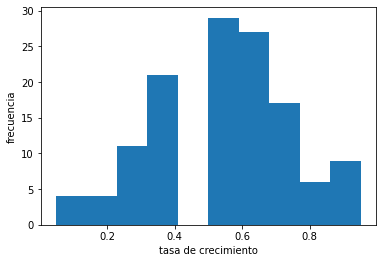

In [9]:
# graficamos un histograma para conocer la distribución de las tasas de crecimiento
plt.hist(success_emp)
plt.xlabel('tasa de crecimiento')
plt.ylabel('frecuencia')
plt.show()

## Cargamos los datos presupuestales y armamos el calendario de desembolsos

In [10]:
dfb = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/base_presupuesto.csv')
dfb = dfb.groupby('ODS').sum()

# armamos el calendario de desembolsos (B_sequence)
programs = sorted(dfb.index.values.astype(float).astype(int))
B_sequence = [[] for target in programs]
subperiods = max_steps/num_years
for i, program in enumerate(programs):
    for year in anios_c:
        for x in range(int(subperiods)):
            B_sequence[i].append( dfb[dfb.index==int(float(program))][year].values[0]/subperiods )   
B_sequence = np.array(B_sequence)

# armamos una tabla vinculando cada indicador a sus ODS
budget_hash = dict([ (i, ods[(ods!='nan') & (ods != '10.0')].astype(float).astype(int).tolist()) for i, ods in enumerate(datos[['ODS1', 'ODS2']].values.astype(str)) ])

In [11]:
# imprimimos calendario de desembolsos
B_sequence

array([[1.03992689e+08, 1.03992689e+08, 1.03992689e+08, 1.03992689e+08,
        1.03992689e+08, 1.03992689e+08, 9.13640841e+07, 9.13640841e+07,
        9.13640841e+07, 9.13640841e+07, 9.13640841e+07, 9.13640841e+07,
        1.40993218e+08, 1.40993218e+08, 1.40993218e+08, 1.40993218e+08,
        1.40993218e+08, 1.40993218e+08, 1.17763385e+08, 1.17763385e+08,
        1.17763385e+08, 1.17763385e+08, 1.17763385e+08, 1.17763385e+08,
        9.90095022e+07, 9.90095022e+07, 9.90095022e+07, 9.90095022e+07,
        9.90095022e+07, 9.90095022e+07, 1.11060438e+08, 1.11060438e+08,
        1.11060438e+08, 1.11060438e+08, 1.11060438e+08, 1.11060438e+08,
        1.07519006e+08, 1.07519006e+08, 1.07519006e+08, 1.07519006e+08,
        1.07519006e+08, 1.07519006e+08, 1.21118509e+08, 1.21118509e+08,
        1.21118509e+08, 1.21118509e+08, 1.21118509e+08, 1.21118509e+08,
        3.44150022e+08, 3.44150022e+08, 3.44150022e+08, 3.44150022e+08,
        3.44150022e+08, 3.44150022e+08],
       [1.26740844e+07,

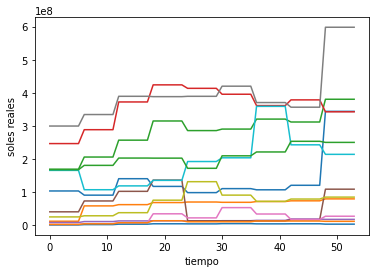

In [12]:
# graficamos las series del calendario de desembolsos
for serie in B_sequence:
    plt.plot(serie)
plt.xlabel('tiempo')
plt.ylabel('soles reales')
plt.show()

In [13]:
# imprimimos la tabla de vinculación entre indicadores y ODS
budget_hash

{0: [1],
 1: [1],
 2: [1],
 3: [1, 2],
 4: [1],
 5: [1],
 6: [1],
 7: [1, 11],
 8: [1, 11],
 9: [1, 11],
 10: [1, 11],
 11: [1, 11],
 12: [1, 11],
 13: [1],
 14: [2],
 15: [2],
 16: [2],
 17: [2],
 18: [3],
 19: [3],
 20: [3],
 21: [3],
 22: [3],
 23: [3],
 24: [3, 5],
 25: [3],
 26: [3],
 27: [3],
 28: [3],
 29: [3, 11],
 30: [3, 5],
 31: [3],
 32: [3],
 33: [3],
 34: [3],
 35: [3],
 36: [4],
 37: [4],
 38: [4],
 39: [4],
 40: [4],
 41: [4],
 42: [4],
 43: [4],
 44: [4],
 45: [4, 5],
 46: [4],
 47: [4, 11],
 48: [4, 11],
 49: [4, 11],
 50: [4],
 51: [4],
 52: [4],
 53: [4],
 54: [4],
 55: [4],
 56: [4],
 57: [4],
 58: [5, 16],
 59: [5, 16],
 60: [5, 16],
 61: [5],
 62: [5],
 63: [5],
 64: [5],
 65: [5],
 66: [5],
 67: [5],
 68: [5],
 69: [5],
 70: [5, 9],
 71: [5],
 72: [6, 11],
 73: [6, 11],
 74: [6, 11],
 75: [6, 11],
 76: [7, 11],
 77: [7, 11],
 78: [8],
 79: [8],
 80: [8],
 81: [8],
 82: [8],
 83: [8],
 84: [8],
 85: [8],
 86: [8],
 87: [9],
 88: [9],
 89: [9],
 90: [9],
 91: [9],

## Calibramos IPP y obtenemos los parámetros y métricas de bondad de ajuste

In [17]:
# hiperparámetros extra
parallel_processes = 2 # número de procesos paralelos
tolerance = .1 # tolerancia del error promedio

parametros_calibrados = calibrator.calibrate(I0, A, R, cc, rl, scalar, IF, success_emp, B_sequence, budget_hash, num_years, max_steps, min_value, tolerance, parallel_processes)

iteración: 1 ; muestras: 10 ; error: 1041310.7805438446
iteración: 2 ; muestras: 10 ; error: 521328.5933188446
iteración: 3 ; muestras: 10 ; error: 266595.0963424424
iteración: 4 ; muestras: 10 ; error: 131013.70971360434
iteración: 5 ; muestras: 10 ; error: 63533.95625066174
iteración: 6 ; muestras: 10 ; error: 32410.896159584518
iteración: 7 ; muestras: 10 ; error: 16602.573340764004
iteración: 8 ; muestras: 10 ; error: 8227.465481501493
iteración: 9 ; muestras: 10 ; error: 4064.62235990301
iteración: 10 ; muestras: 10 ; error: 2013.684940946029
iteración: 11 ; muestras: 10 ; error: 986.6435003566602
iteración: 12 ; muestras: 10 ; error: 490.5015985432535
iteración: 13 ; muestras: 10 ; error: 249.91832625569225
iteración: 14 ; muestras: 10 ; error: 124.85459253600571
iteración: 15 ; muestras: 10 ; error: 60.72403681112423
iteración: 16 ; muestras: 10 ; error: 30.356017869629525
iteración: 17 ; muestras: 10 ; error: 15.021790887100101
iteración: 18 ; muestras: 10 ; error: 7.2287838512

In [18]:
# imprimimos resultados
parametros_calibrados

,alphas,beta,steps,years,error_alpha,error_beta,scalar,min_value,GoF_alpha,GoF_beta
0,0.000558,1.861909e-07,54.0,9.0,-0.000004,-0.001088,100.0,0.01,0.961027,0.997191
1,0.000448,2.625663e-07,NaN,NaN,-0.000002,-0.010082,NaN,NaN,0.975321,0.979835
2,0.023947,2.285011e-07,NaN,NaN,-0.000219,-0.020500,NaN,NaN,0.950532,0.947096
3,0.000391,4.837963e-08,NaN,NaN,0.000003,0.011060,NaN,NaN,0.970896,0.977881
4,0.066948,1.559537e-07,NaN,NaN,0.000463,0.007796,NaN,NaN,0.950498,0.971649
...,...,...,...,...,...,...,...,...,...,...
123,0.000725,7.121429e-08,NaN,NaN,-0.000010,-0.007893,NaN,NaN,0.903756,0.971297
124,0.000465,7.491588e-08,NaN,NaN,0.000004,-0.008801,NaN,NaN,0.958850,0.977289
125,0.180311,1.479410e-07,NaN,NaN,0.004049,0.021023,NaN,NaN,0.933549,0.971003
126,0.779562,1.356680e-07,NaN,NaN,-0.013337,-0.018891,NaN,NaN,0.929663,0.962217


In [19]:
# cargamos los parámetros estimados para el reporte y los imprimimos
parametros_reporte = pd.read_csv('https://raw.githubusercontent.com/oguerrer/IPP_Lima/main/data/parametros.csv')
parametros_reporte

,alphas,beta,steps,years,error_alpha,error_beta,scalar,min_value,GoF_alpha,GoF_beta
0,0.000529,1.782817e-07,54.0,9.0,3.454704e-06,0.010382,100.0,0.01,0.965453,0.973206
1,0.000439,2.576923e-07,NaN,NaN,-6.269388e-07,-0.008174,NaN,NaN,0.993731,0.983651
2,0.023749,2.216160e-07,NaN,NaN,6.114264e-05,0.007325,NaN,NaN,0.986213,0.981096
3,0.000398,4.940167e-08,NaN,NaN,-1.131800e-06,-0.000294,NaN,NaN,0.988682,0.999412
4,0.067935,1.575292e-07,NaN,NaN,7.325213e-05,0.001802,NaN,NaN,0.992174,0.993447
...,...,...,...,...,...,...,...,...,...,...
123,0.000686,6.783543e-08,NaN,NaN,-4.879169e-07,-0.003378,NaN,NaN,0.995121,0.987715
124,0.000488,7.410137e-08,NaN,NaN,2.801090e-06,0.005639,NaN,NaN,0.971989,0.985447
125,0.191054,1.554571e-07,NaN,NaN,-1.029101e-03,-0.011204,NaN,NaN,0.983111,0.984547
126,0.750630,1.351602e-07,NaN,NaN,-7.238833e-03,-0.020799,NaN,NaN,0.961825,0.958402


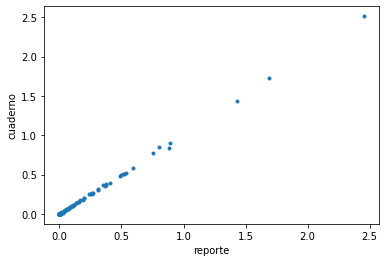

In [27]:
# comparamos los parámetros alfa
x = parametros_reporte['alphas'].values
y = parametros_calibrados['alphas'].values
plt.plot(x, y, '.')
plt.xlabel('reporte')
plt.ylabel('cuaderno')
plt.show()

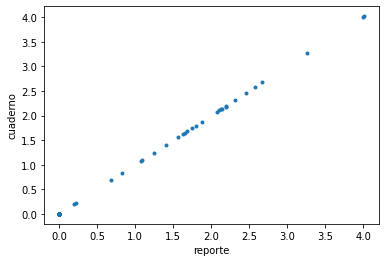

In [28]:
# comparamos los parámetros beta
x = parametros_reporte['beta'].values
y = parametros_calibrados['beta'].values
plt.plot(x, y, '.')
plt.xlabel('reporte')
plt.ylabel('cuaderno')
plt.show()

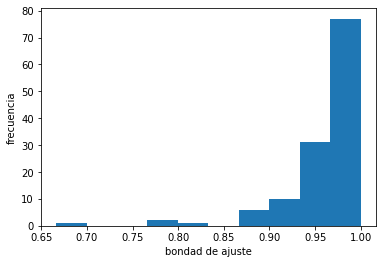

In [30]:
# histograma de la bondad de ajuste de las alfas
plt.hist(parametros_calibrados['GoF_alpha'].values)
plt.xlabel('bondad de ajuste')
plt.ylabel('frecuencia')
plt.show()

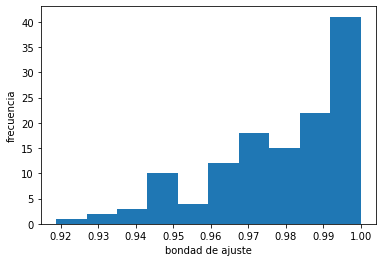

In [31]:
# histograma de la bondad de ajuste de las betas
plt.hist(parametros_calibrados['GoF_beta'].values)
plt.xlabel('bondad de ajuste')
plt.ylabel('frecuencia')
plt.show()